In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

<BarContainer object of 51 artists>

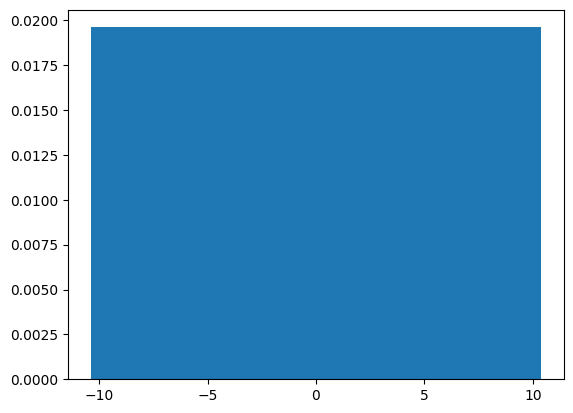

In [2]:
vmin, vmax = -10., 10.
nsup = 51 # number of supports
support = np.linspace(vmin, vmax, nsup)
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support, probs)

In [3]:
def update_dist(r, support, probs, lim=(-10., 10.), gamma=0.8):
    nsup = probs.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.)
    bj = np.round((r - vmin) / dz)
    bj = int(np.clip(bj, 0, nsup - 1))
    m = probs.clone()
    j = 1
    for i in range(bj, 1, -1):
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1
    j = 1
    for i in range(bj, nsup - 1, 1):
        m[i] += np.power(gamma, j) * m[i - 1]
        j += 1
    m /= m.sum()
    return m

<BarContainer object of 51 artists>

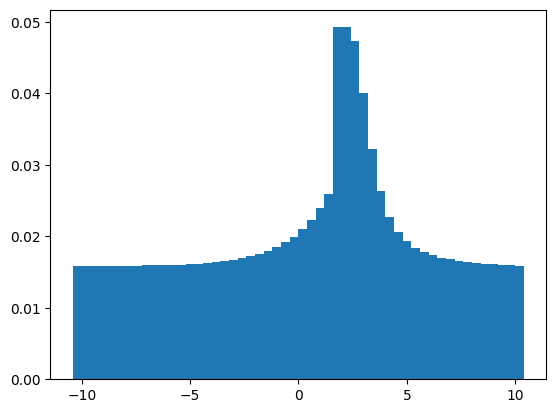

In [4]:
posterior = update_dist(2, support, z3)
plt.bar(support, posterior)

下面的例子展示当我们得到一系列的奖励之后，概率分布函数的变化。

<BarContainer object of 51 artists>

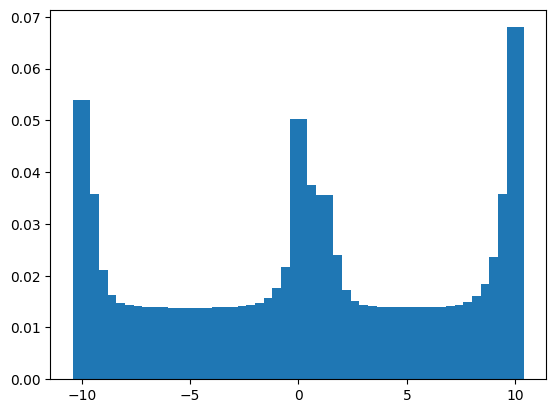

In [5]:
ob_rewards = [10, 10, 10, 0, 1, 0, -10, -10, 10, 10]
z = torch.from_numpy(probs).float()
for i in range(len(ob_rewards)):
    z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), z, gamma=0.5)
plt.bar(support, z)

<BarContainer object of 51 artists>

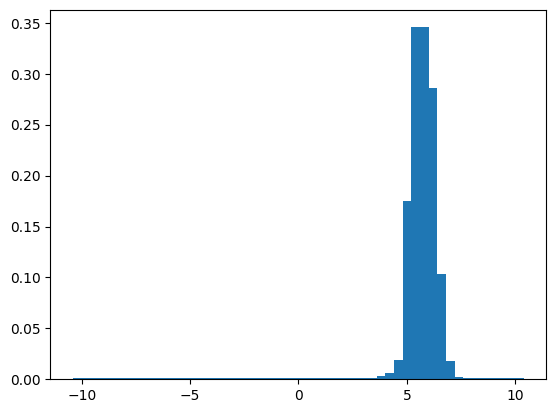

In [6]:
ob_rewards = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
z = torch.from_numpy(probs).float()
for i in range(len(ob_rewards)):
    z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), z, gamma=0.5)
plt.bar(support, z)

下面定义分布式 DQN 网络。需要注意的是，输入 `theta` 为整个网络的参数，其中每一层的参数都被展平到 `theta` 里，通过下标索引取出具体某一层的参数。在这个简单的三层网络里，第一层是 $128 \times 100$，第二层是 $100 \times 25$，第三层分 `aspace` 个输出（因为在 Freeway 这个游戏里，只有三个动作），每个输出对应一个层参数，具体在下面函数定义的 `for` 循环里。

使用一整个平铺参数的好处在于，可以对这个变量进行整体的反向传播，另外，在这个 Freeway 游戏的强化学习中，我们也会使用到 target network，这样我们只需要复制出来一整个平铺参数就可以了。

In [7]:
def dist_dqn(x, theta, aspace=3):
    dim0, dim1, dim2, dim3 = 128, 100, 25, 51
    t1 = dim0 * dim1
    t2 = dim2 * dim1
    # 128 x 100
    theta1 = theta[0:t1].reshape(dim0, dim1)
    # 100 x 25
    theta2 = theta[t1:t1 + t2].reshape(dim1, dim2)
    l1 = x @ theta1 # (Batch x 128) dot (128 x 100) = (Batch x 100)
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 # (Batch x 100) dot (100 x 25) = (Batch x 25)
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace):
        step = dim2 * dim3
        theta5_dim = t1 + t2 + i * step
        # 25 x 51
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2, dim3)
        # (Batch x 25) dot (25 x 51) = (Batch x 51)
        l3_ = l2 @ theta5
        l3.append(l3_)

    # (Batch x 3 x 51)
    #    ^     ^    ^
    #  dim0  dim1  dim2
    # stack at dim1
    # softmax at dim2
    l3 = torch.stack(l3, dim=1)
    l3 = torch.nn.functional.softmax(l3, dim=2)
    return l3.squeeze()

In [8]:
def get_target_dist(dist_batch, # B x 3 x 51
                    action_batch,
                    reward_batch,
                    support,
                    lim=(-10., 10.),
                    gamma=0.8):
    nsup = support.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin) / (nsup - 1.)
    target_dist_batch = dist_batch.clone()

    # loops through the batch dimension
    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        # get the action distribution
        dist = dist_full[action]
        r = reward_batch[i]
        # termianl state, the target is a degenerated distribution
        # at the reward value
        if r != -1:
            target_dist = torch.zeros(nsup)
            bj = np.round((r - vmin) / dz)
            bj = int(np.clip(bj, 0, nsup - 1))
            target_dist[bj] = 1.
        else:
            target_dist = update_dist(r, support, dist, lim=lim, gamma=gamma)
        target_dist_batch[i, action, :] = target_dist

    return target_dist_batch

In [9]:
def lossfn(x, y):
    loss = torch.Tensor([0.])
    loss.requires_grad = True
    for i in range(x.shape[0]):
        loss_ = -1 * torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss


下面先用一个例子来进行模拟。首先初始化状态空间为 3，然后根据展平的参数形状初始化两个神经网络参数 `theta` 和 `theta_2`。随机初始化了两个状态，在状态 1 中采取动作 0 以及获得奖励 0，在状态 2 中采取动作 2 以及获得奖励 10。

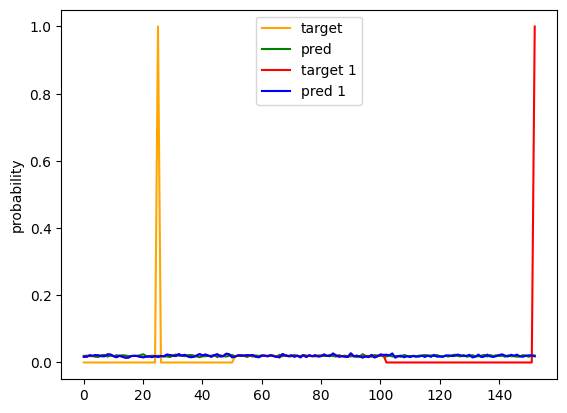

In [10]:
aspace = 3
tot_params = 128 * 100 + 25 * 100 + aspace * 25 * 51
theta = torch.randn(tot_params) / 10.
theta.requires_grad = True
theta_2 = theta.detach().clone()

vmin, vmax = -10, 10
gamma = 0.9
lr = 0.00001
update_rate = 75
support = torch.linspace(-10, 10, 51)
state = torch.randn(2, 128) / 10.
action_batch = torch.Tensor([0, 2])
reward_batch = torch.Tensor([0, 10])
losses = []

pred_batch = dist_dqn(state, theta, aspace=aspace)
target_dist = get_target_dist(
    pred_batch,
    action_batch,
    reward_batch,
    support,
    lim=(vmin, vmax),
    gamma=gamma)

plt.ylabel('probability')
plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()), color='orange', label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color='green', label='pred')
plt.plot((target_dist.flatten(start_dim=1)[1].data.numpy()), color='red', label='target 1')
plt.plot((pred_batch.flatten(start_dim=1)[1].data.numpy()), color='blue', label='pred 1')
plt.legend()

可以看到上图，由于目前没有经过训练，所以 target distribution 基本上是一个均匀分布，而对于状态 1 来说，因为采取了动作 0，所以在 $[0, 50]$ 这个区间有个大概率的尖峰，对于状态 2 来说，因为采取了动作 2，所以在 $[100, 150]$ 这个区间有个尖峰。需要注意的是，由于将参数打平了，每个动作分布占 50 个数据点，所以 $[0, 50]$ 对应动作 0，$[51, 100]$ 对应动作 1，$[101, 150]$ 对应动作 2。

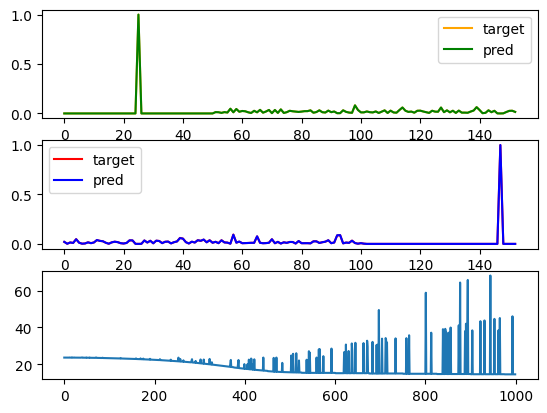

In [11]:
for i in range(1000):
    # adds some random noise to the rewards to mitigate overfitting
    reward_batch = torch.Tensor([0, 8]) + torch.randn(2) / 10.0
    pred_batch = dist_dqn(state, theta, aspace=aspace)
    pred_batch2 = dist_dqn(state, theta_2, aspace=aspace)
    # use the target network's distributions to create the target distribution
    # for learing
    target_dist = get_target_dist(
        pred_batch2,
        action_batch,
        reward_batch,
        support,
        lim=(vmin, vmax),
        gamma=gamma)
    # do not back propagate the target network
    loss = lossfn(pred_batch, target_dist.detach())
    losses.append(loss.item())
    loss.backward()

    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True

    # synchronizes the target network parameters with the main model parameters
    if i % update_rate == 0:
        theta_2 = theta.detach().clone()

fig, ax = plt.subplots(3, 1)
ax[0].plot((target_dist.flatten(start_dim=1)[0].data.numpy()), color='orange', label='target')
ax[0].plot((pred_batch.flatten(start_dim=1)[0].data.numpy()), color='green', label='pred')
ax[0].legend()
ax[1].plot((target_dist.flatten(start_dim=1)[1].data.numpy()), color='red', label='target')
ax[1].plot((pred_batch.flatten(start_dim=1)[1].data.numpy()), color='blue', label='pred')
ax[1].legend()
ax[2].plot(losses)

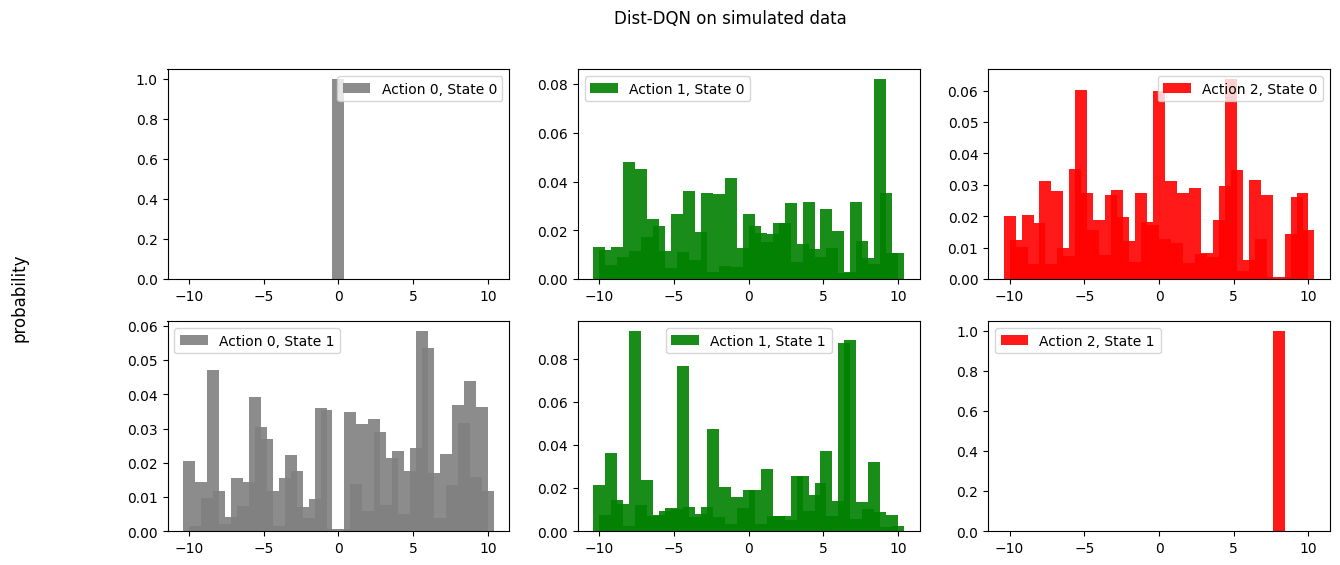

In [12]:
tpred = pred_batch
cs = ['gray','green','red']
num_batch = 2
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig,ax = plt.subplots(nrows=num_batch,ncols=aspace)
fig.suptitle('Dist-DQN on simulated data')
fig.supylabel('probability')
fig.set_figwidth(15)
fig.set_figheight(6)

for j in range(num_batch): #A 
    for i in range(tpred.shape[1]): #B
        ax[j,i].bar(support.data.numpy(),tpred[j,i,:].data.numpy(),\
                label='Action {}, State {}'.format(i, j),alpha=0.9,color=cs[i])
        ax[j, i].legend()

In [13]:
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state, dim=1)
    return p_state

def get_action(dist, support):
    actions = []
    for b in range(dist.shape[0]):
        expectations = [support @ dist[b, a, :] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)

    actions = torch.Tensor(actions).int()
    return actions

In [21]:
import gymnasium
from collections import deque
env = gymnasium.make('ALE/Freeway-ram-v5')
aspace = 3
env.unwrapped.get_action_meanings()

['NOOP', 'UP', 'DOWN']

In [34]:
vmin, vmax = -10., 10.
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup - 1)
support = torch.linspace(vmin, vmax, nsup)

replay = deque(maxlen=replay_size)
lr = 0.0001
gamma = 0.1
epochs = 1300
eps = 0.2
eps_min = 0.05
priority_level = 5
update_freq = 25

tot_params = 128 * 100 + 25 * 100 + aspace * 25 * 51
theta = torch.randn(tot_params) / 10.
theta.requires_grad = True
theta_2 = theta.detach().clone()
losses = []
cum_rewards = []
renders = []
state = preproc_state(env.reset()[0])

In [35]:
from random import shuffle

for i in range(epochs):
    pred = dist_dqn(state, theta, aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(), support).item()
    
    state2, reward, done, truncated, info = env.step(action)
    state2 = preproc_state(state2)

    if reward == 1: cum_rewards.append(1)

    reward = 10 if reward == 1 else reward
    reward = -10 if done else reward
    reward = -1 if reward == 0 else reward
    exp = (state, action, reward, state2)
    replay.append(exp)

    if reward == 10:
        for e in range(priority_level):
            replay.append(exp)

    shuffle(replay)
    state = state2

    if len(replay) == replay_size:
        indx = np.random.randint(low=0, high=len(replay), size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps], dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps], dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach(), theta, aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(), theta_2, aspace=aspace)
        target_dist = get_target_dist(
            pred2_batch,
            action_batch,
            reward_batch,
            support,
            lim=(vmin, vmax),
            gamma=gamma)
        loss = lossfn(pred_batch, target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            theta -= lr * theta.grad
        theta.requires_grad = True

    if i % update_freq == 0:
        theta_2 = theta.detach().clone()

    if i > 100 and eps > eps_min:
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec

    if done:
        state = preproc_state(env.reset()[0])
        done = False

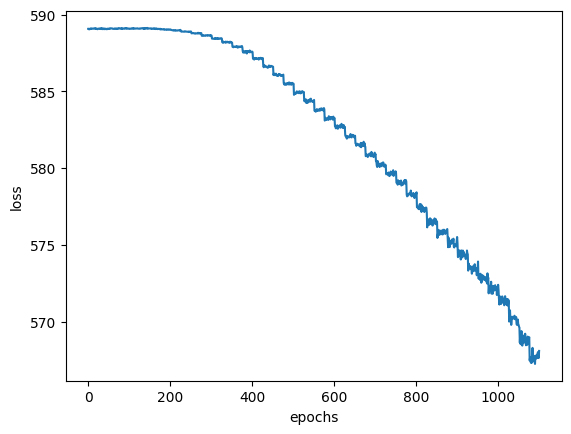

In [36]:

plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(losses)